# Aprendizaje de máquina 1

## Ejercicio clase 5

-------------------------------------------------------------------------------------------------------
# Carga de librerías

In [172]:
# Importamos librerias
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()
import statistics as stat
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
pd.set_option('display.max_columns', None)

-------------------------------------------------------------------------------------------------------
# Carga de dataset

In [173]:
# Cargamos el dataset
df_heart = pd.read_csv("./heart.csv")

-------------------------------------------------------------------------------------------------------
# Análisis exploratorio inicial

In [174]:
# Visualizamos primeras filas
df_heart.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [175]:
df_heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [176]:
df_heart.shape

(303, 14)

In [177]:
df_heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [178]:
print(df_heart.apply(lambda col: len(col.unique())))

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64


Variables de entrada: Todas las columnas excepto por la última "Target".

- Chest pain type es una variable categórica de 4 valores únicos. Aplicamos one hot encoding.
- Restecg y ca parece tener sentido que sean enteros sucesivos, podemos dejarlo así o aplicar también one hot encoding.
- Thal es una variable categórica, aplicamos one hot encoding

In [179]:
print(df_heart.apply(lambda col: col.isnull().sum()))

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Observamos que no hay presencia de valores nulos

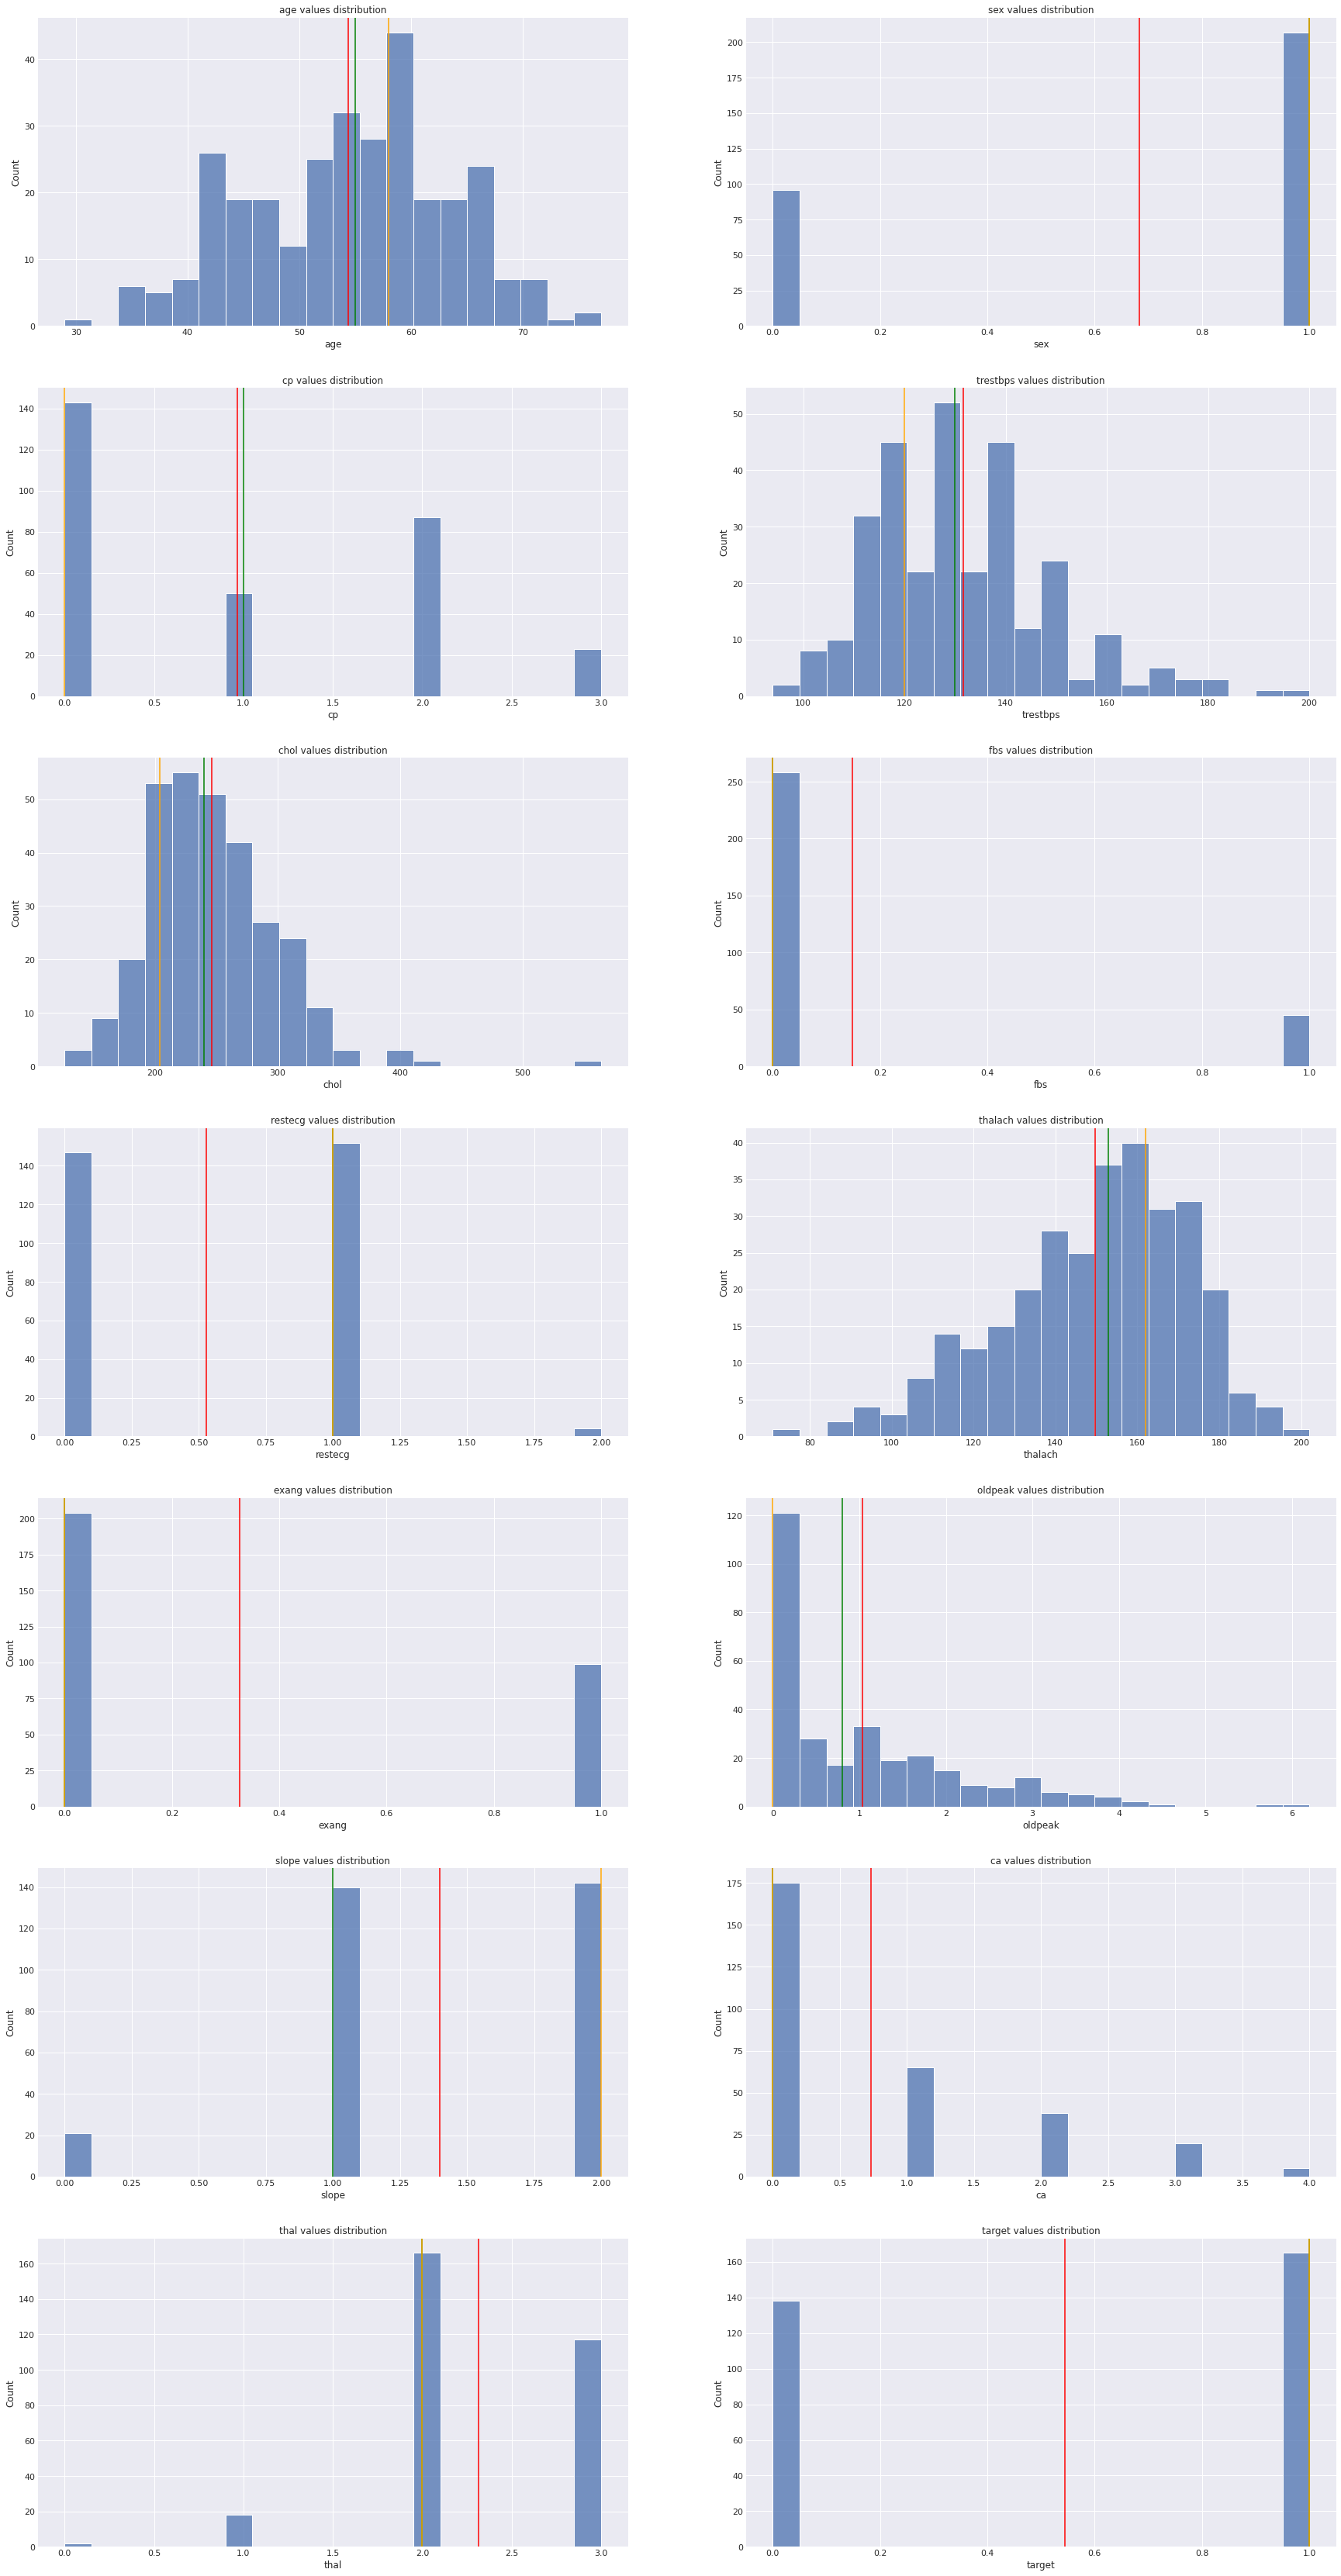

In [180]:
# Extra todas las gráficas de distribución para variables numéricas
def plot_dist_numeric():
    
    fig,axes = plt.subplots(7,2,figsize=(30,60))
    
    for i,series in enumerate(df_heart.columns):
        j = i // 2
        k = i % 2
        numerical_series=df_heart[series]
        sns.histplot(numerical_series, bins=20, ax=axes[j,k]).set_title(series+ ' values distribution')   
        axes[j,k].axvline(np.mean(numerical_series),color='red',label='Mean')
        axes[j,k].axvline(np.median(numerical_series),color='green',label='Median')
        axes[j,k].axvline(stat.mode(numerical_series),color='orange',label='Mode')
    
plot_dist_numeric()

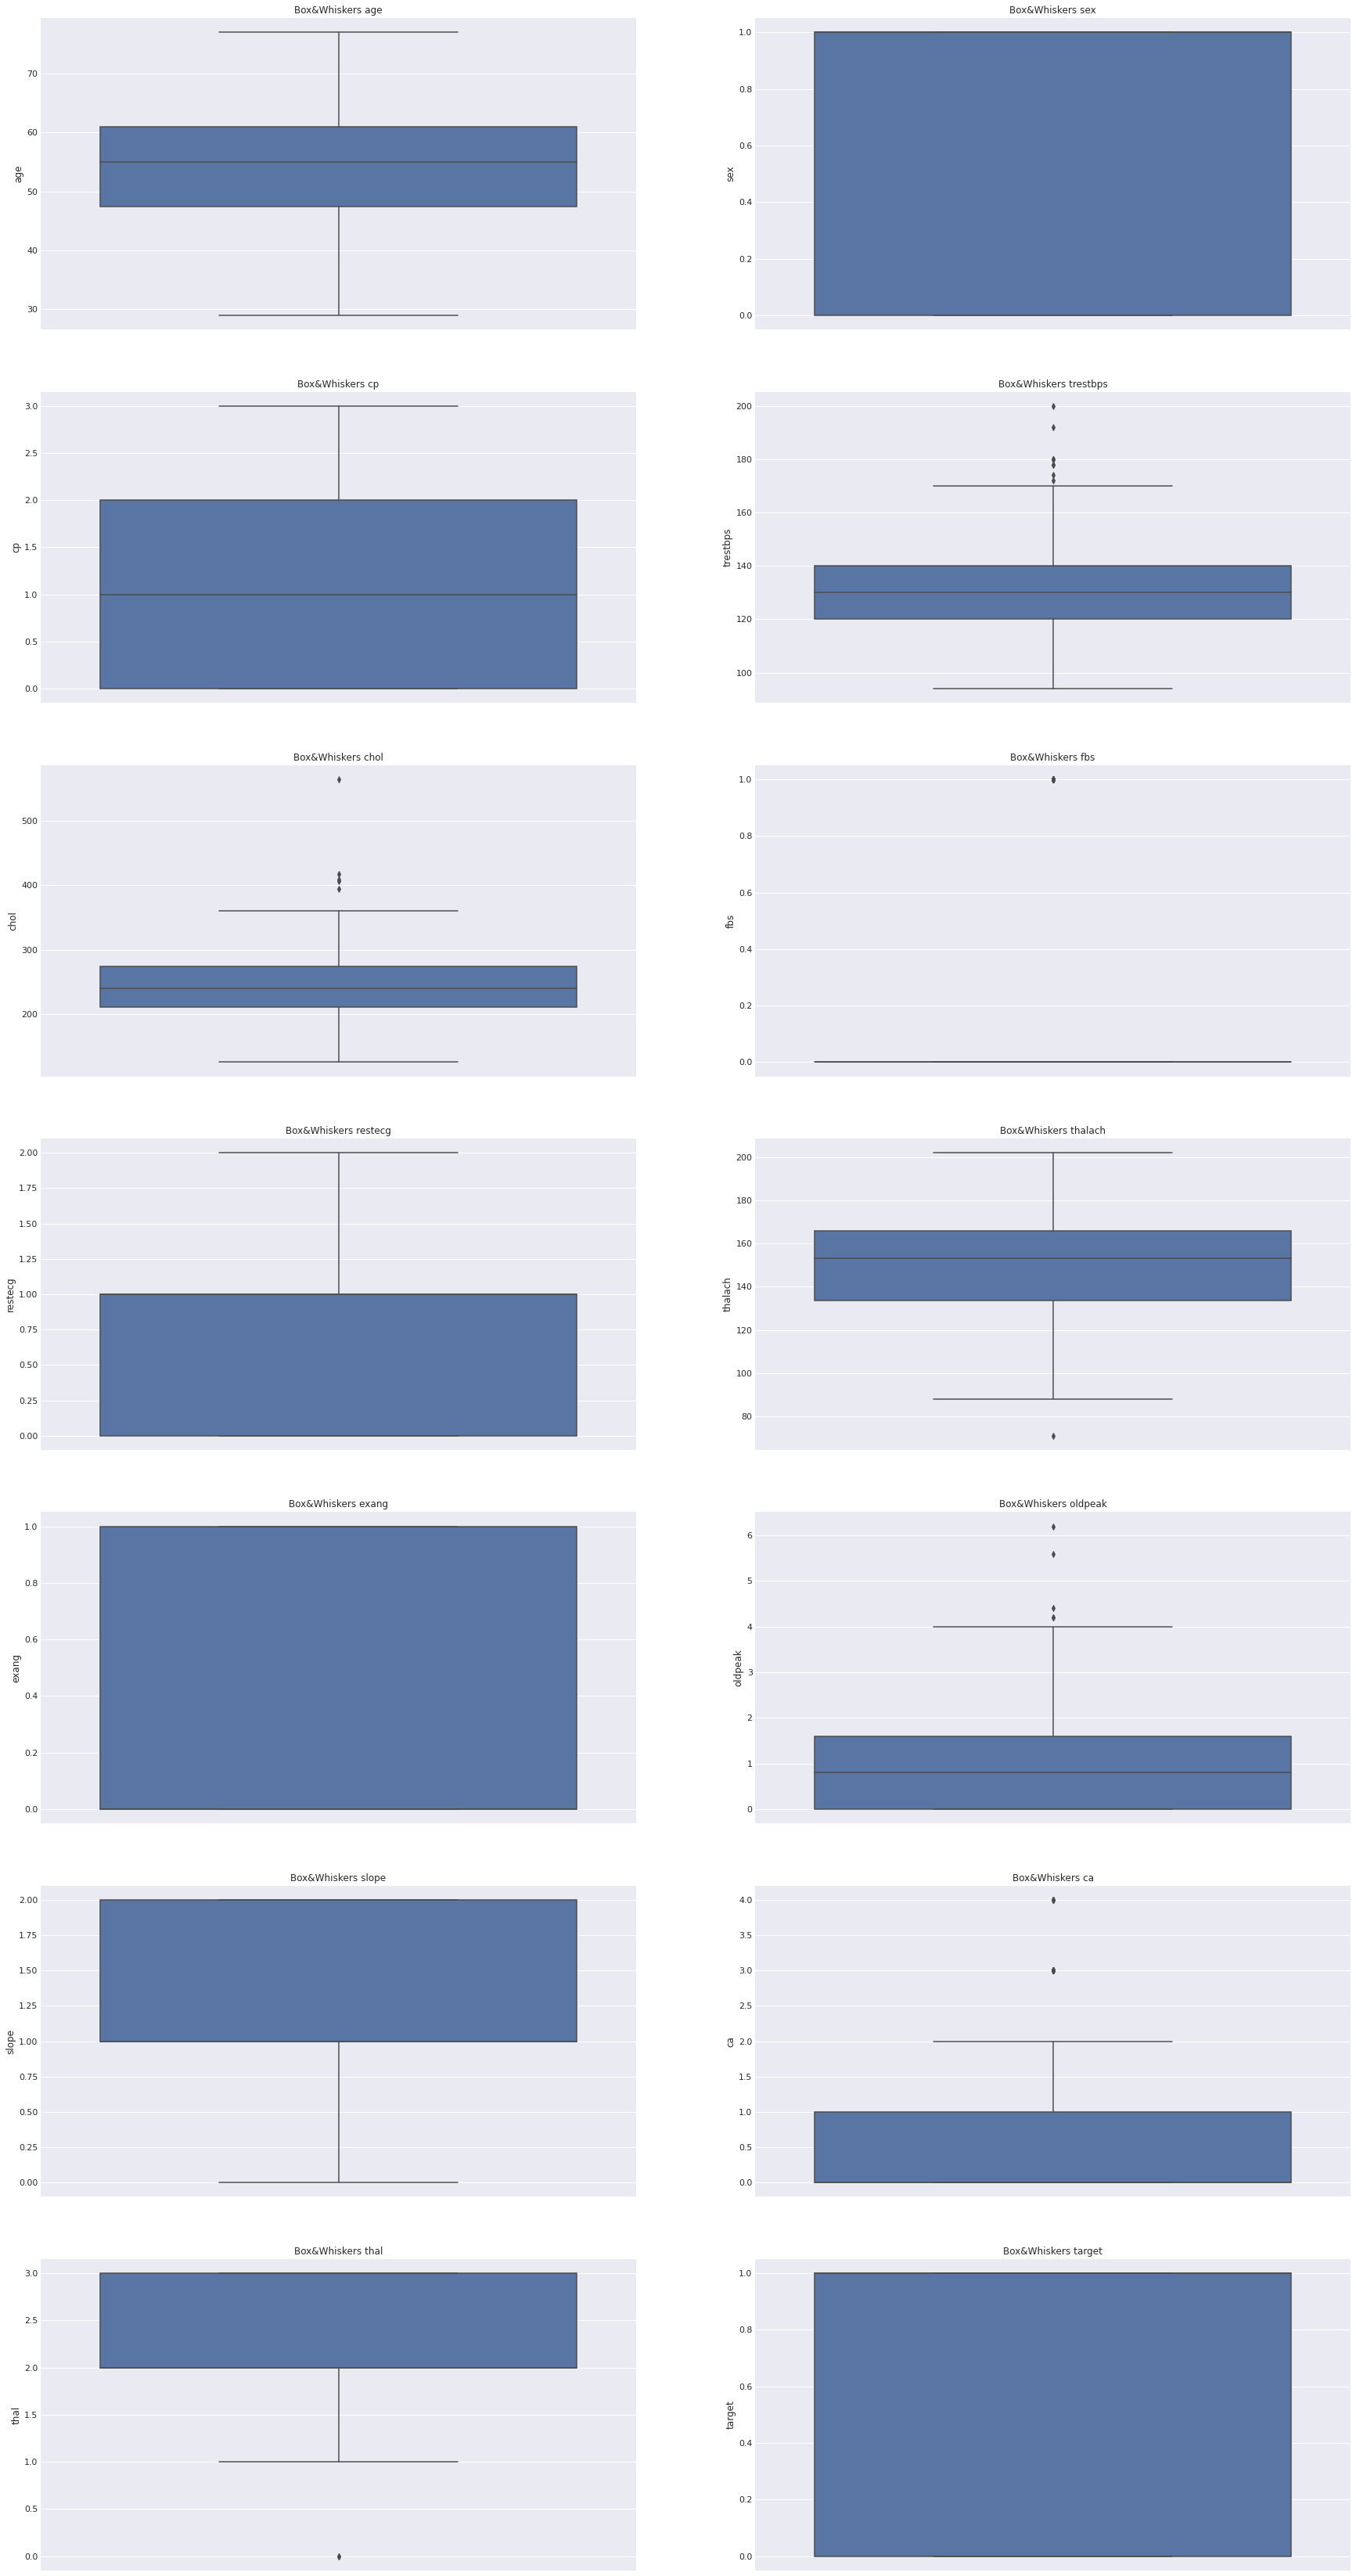

In [181]:
# Extra todas las gráficas de distribución para variables numéricas
def plot_box_numeric():
    
    fig,axes = plt.subplots(7,2,figsize=(30,60))
    
    for i,series in enumerate(df_heart.columns):
        j = i // 2
        k = i % 2
        numerical_series=df_heart[series]
        sns.boxplot(y=numerical_series, ax=axes[j,k])
        axes[j,k].set_title('Box&Whiskers ' + series)
    
plot_box_numeric()

In [182]:
print(df_heart.groupby('target')['target'].count())

target
0    138
1    165
Name: target, dtype: int64


Variables de salida: "Target". La salida es un entero  0 o 1 que representa riesgo de ataque cardíaco. Estamos ante un problema de clasificación binaria.

Notamos que las clases estan balanceadas.

-------------------------------------------------------------------------------------------------------
# Esquema de validación de resultados

Particionaremos el dataset en entrenamiento y validación. También dejaremos una porción para realizar el testeo final del modelo. La partición se realizará 70% entrenamiento, 15% validacion, 15% testeo.

In [183]:
x = df_heart.drop('target',axis=1)
y = df_heart['target']

In [184]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(242, 13)
(242,)
(61, 13)
(61,)


-------------------------------------------------------------------------------------------------------
# Ingeniería de features básica

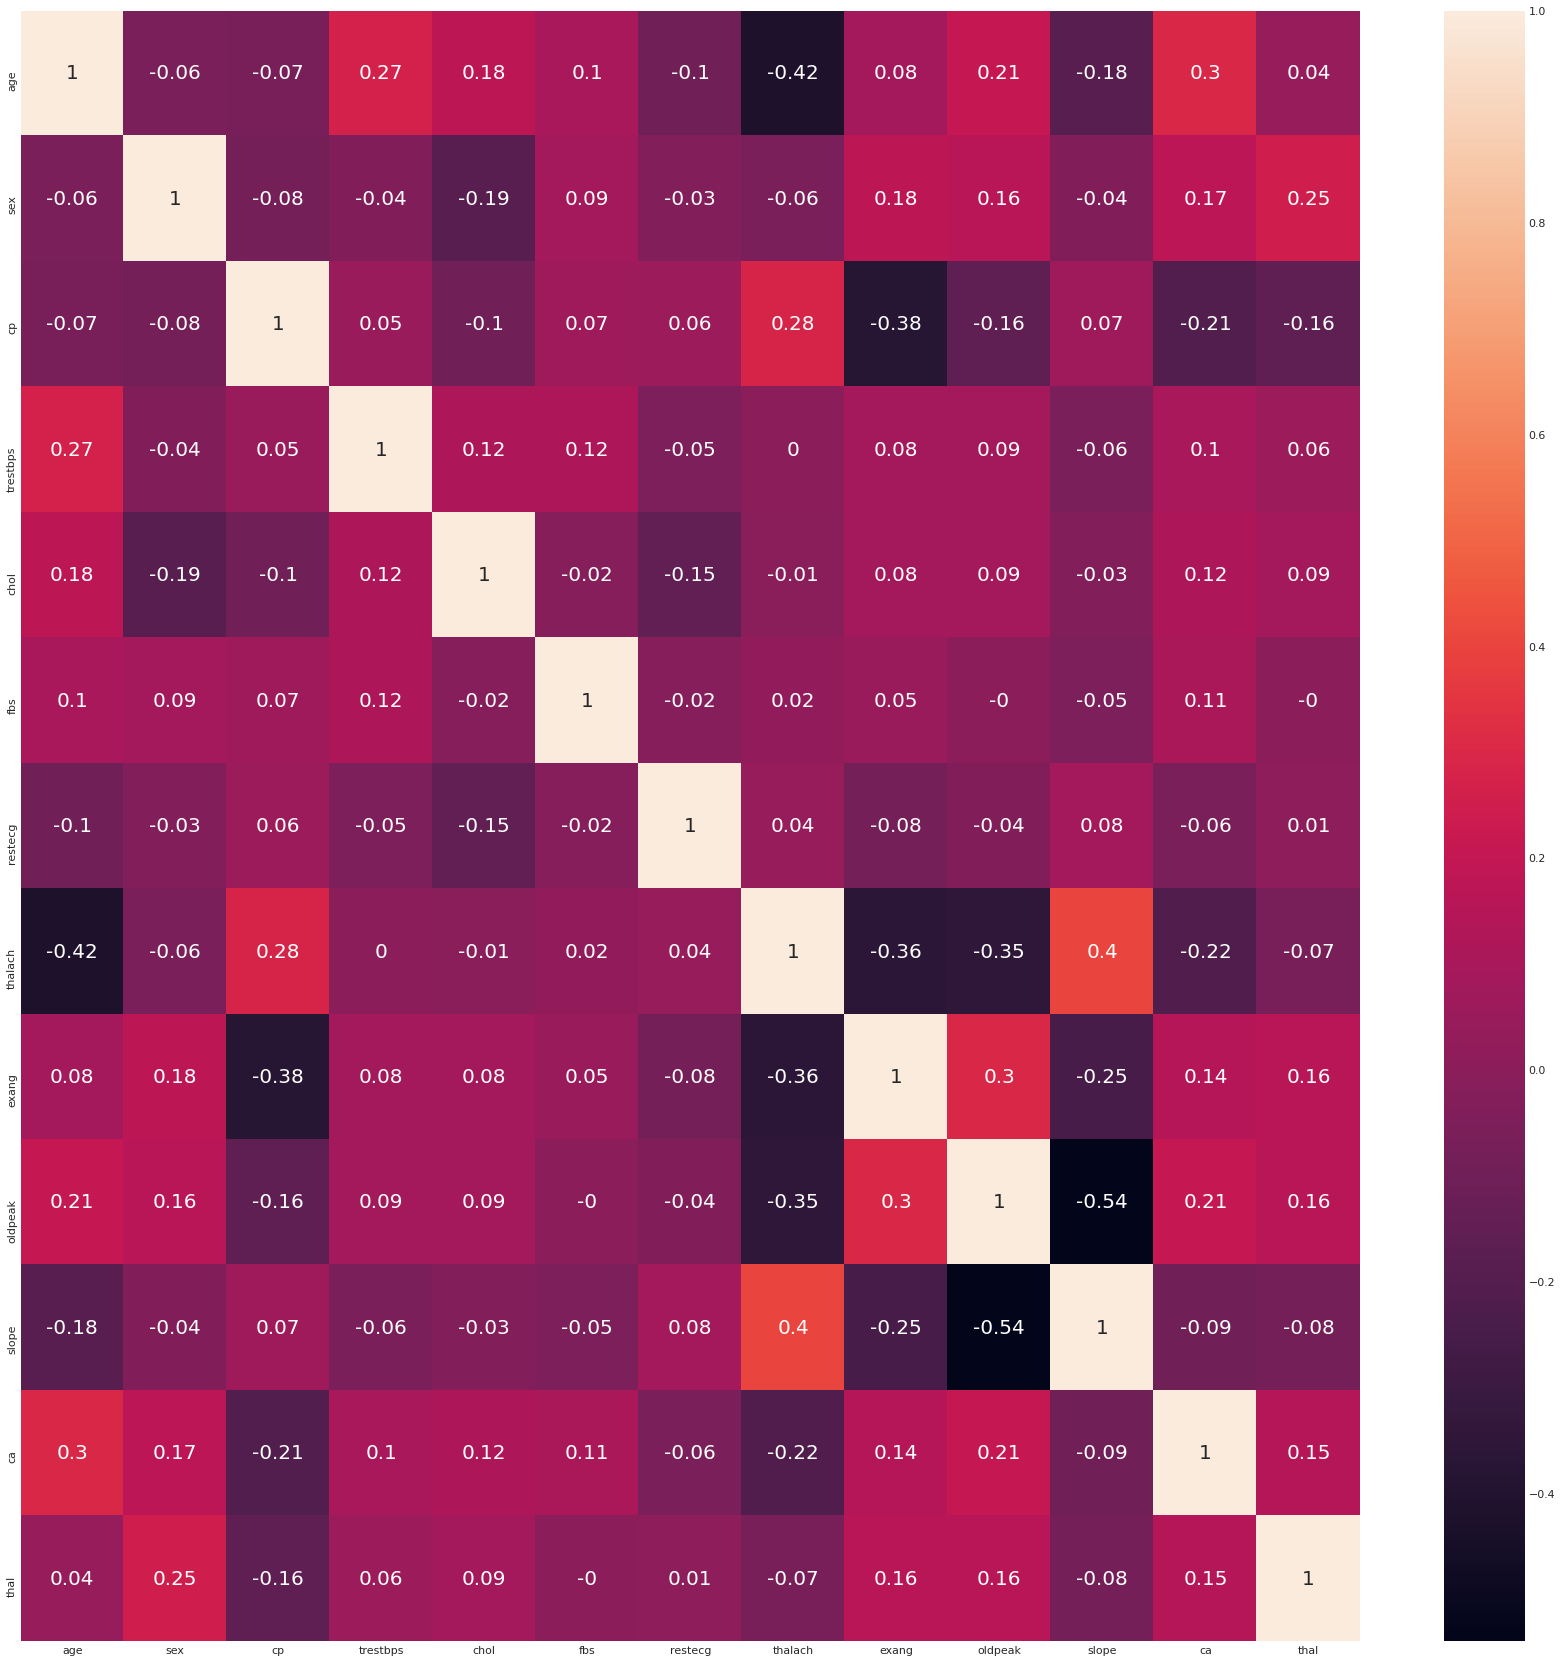

In [185]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = x_train.corr().round(2)
fig,axes = plt.subplots(1,1,figsize=(30,30))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

Observando la matriz de correlación podemos mencionar:
-	Hay una leve correlación entre oldpeak y slope lo cual es coherente ya que ambos se refieren al mismo examen ST

## variables de mayor importancia

Como primer método proponemos aplicar información mutua. En este método se mide el coeficiente de infromación mutua entre las variables de entrada y la variable de salida y se selecciona aquellas con mayor dependencia.

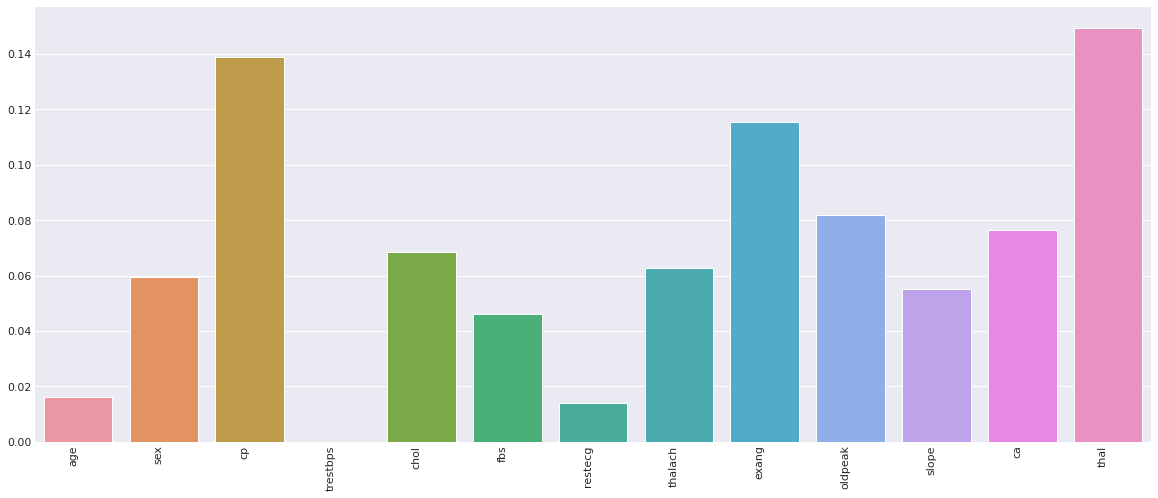

In [186]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

def select_features_mutual_info(X_train, y_train,k= 'all'):  
  fs = SelectKBest(score_func=mutual_info_classif, k=k )  
  fs.fit(X_train, y_train)  
  return fs

fs = select_features_mutual_info(x_train, y_train)
fig,axes = plt.subplots(1,1,figsize=(20,8))
bar = sns.barplot( x = [c for c in x_train.columns], y = fs.scores_,ax=axes)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Como segundo método proponemos aplicar Lasso

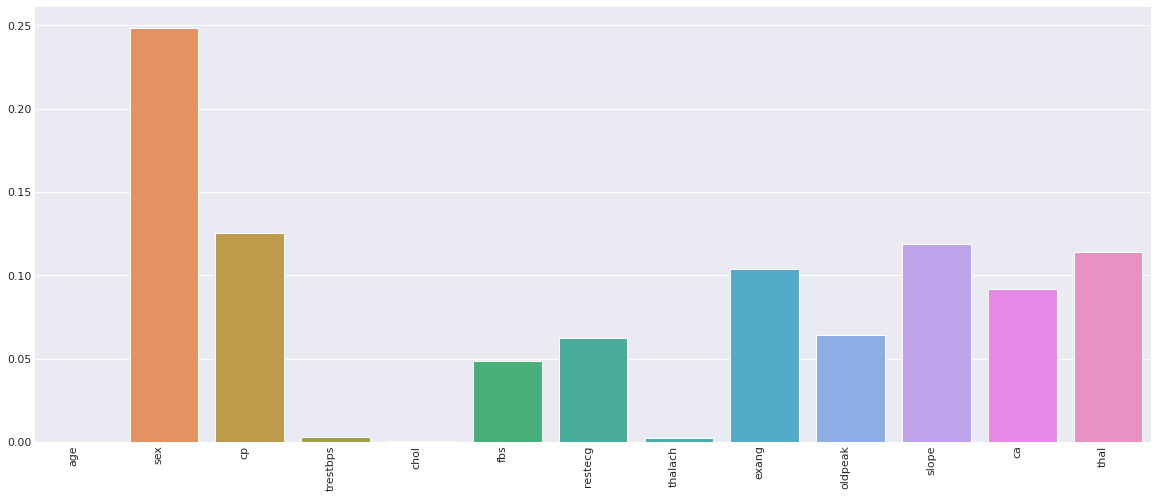

In [187]:
lassoreg = Lasso(alpha=0.0001,normalize=True, max_iter=1000)
lassoreg.fit(x_train, y_train)
fig,axes = plt.subplots(1,1,figsize=(20,8))
bar = sns.barplot( x = [c for c in x_train.columns], \
                  y = np.abs(lassoreg.coef_), ax=axes)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()


-------------------------------------------------------------------------------------------------------
# Entrenamiento de modelos

Dado que es un problema de clasificación binaria, proponemos como modelos la utilización de regresión logística y de Random Forest.

En los pasos siguientes se entrenan diferentes modelos y se evalúa el AUC como métrica de comparación utilizando K-Folds sobre el dataset de entrenamiento.

In [188]:
from sklearn.model_selection import StratifiedKFold

def EvaluateKFolds(m, X, y, k=5):
    train_auc=0
    valid_auc=0
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    
    for train_index, valid_index in kf.split(X, y):
        x_valid = X.iloc[valid_index]
        y_valid = y.iloc[valid_index]
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        model = clone(m[1])
        model.fit(x_train, y_train)
        pred_train = model.predict_proba(x_train)
        pred_valid = model.predict_proba(x_valid)
        if len(pred_train.shape)>1 and (pred_train.shape[1]>1):
            train_auc = train_auc + roc_auc_score(y_train, pred_train[:,1]) / k
            valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid[:,1]) / k
        else:
            train_auc = train_auc + roc_auc_score(y_train, pred_train) / k
            valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid) / k

    return train_auc, valid_auc

### Modelo base

Caso completo. 
- One hot encoding en chast pain, Thal, restecg y ca
- Escalado minmax


In [189]:
class RandomModel(object):

    def fit(self, X, y):
        return None

    def predict_proba(self, X):
        return np.random.randint(0,1, size=X.shape[0])
     

In [190]:
numeric_features = ['age','sex', 'trestbps','chol','fbs',\
                    'thalach', 'exang', 'oldpeak', 'slope']

categorical_features = ['restecg', 'ca', 'cp', 'thal']

categorical_transformer1 = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer1 = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', RandomModel())])


models = [
    ("BaseModel",model1),
]

results = {}


m = models[0]
model_name = m[0]
results[model_name] = {}

train_auc, valid_auc = EvaluateKFolds(m, x_train, y_train, 5)

results[model_name]["Train"] = train_auc
results[model_name]["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results

,Train,Valid
BaseModel,0.5,0.5


### Logistic Regression y Random Forest

Caso completo. 
- One hot encoding en chast pain y Thal
- Comparamos restecg - ca con y sin one hot encoding. 
- Escalado minmax


In [191]:
numeric_features = ['age','sex', 'trestbps','chol','fbs', 'restecg',\
                    'thalach', 'exang', 'oldpeak', 'slope','ca']

categorical_features = ['cp', 'thal']

categorical_transformer1 = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer1 = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', LogisticRegression(max_iter=1000,random_state=5))])

model2 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', RandomForestClassifier(n_estimators=200, random_state=5))])


models = [
    ("LogistiRegression",model1),
    ("RandomForest", model2),
]

results = {}
for m in models:
    model_name = m[0]
    results[model_name] = {}
    
    train_auc, valid_auc = EvaluateKFolds(m, x_train, y_train, 5)
    
    results[model_name]["Train"] = train_auc
    results[model_name]["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results

,Train,Valid
LogistiRegression,0.942607,0.922307
RandomForest,1.000000,0.908278


In [192]:
numeric_features = ['age','sex', 'trestbps','chol','fbs',\
                    'thalach', 'exang', 'oldpeak', 'slope']

categorical_features = ['restecg', 'ca', 'cp', 'thal']

categorical_transformer1 = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer1 = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', LogisticRegression(max_iter=1000,random_state=5))])

model2 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', RandomForestClassifier(n_estimators=200, random_state=5))])


models = [
    ("LogistiRegression",model1),
    ("RandomForest", model2),
]

results = {}
for m in models:
    model_name = m[0]
    results[model_name] = {}
    
    train_auc, valid_auc = EvaluateKFolds(m, x_train, y_train, 5)
    
    results[model_name]["Train"] = train_auc
    results[model_name]["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results

,Train,Valid
LogistiRegression,0.955313,0.929968
RandomForest,1.000000,0.910920


### Deep learning

Caso completo. 
- One hot encoding en chast pain, Thal, restecg y ca
- Escalado minmax

In [193]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

In [194]:
class DeepModel(object):
    
    def __init__(self):
        # create model
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Dense(100))
        self.model.add(tf.keras.layers.Activation('relu'))
        self.model.add(tf.keras.layers.Dense(1))
        self.model.add(tf.keras.layers.Activation('sigmoid'))

        metrics = [tf.keras.metrics.AUC()]

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss='binary_crossentropy',
            metrics=metrics
        )


    def fit(self, X, y):
        self.model.fit(X, y,epochs=50,batch_size=16)

    def predict_proba(self, X):
        return self.model.predict_proba(X)
  


In [195]:
numeric_features = ['age','sex', 'trestbps','chol','fbs',\
                    'thalach', 'exang', 'oldpeak', 'slope']

categorical_features = ['restecg', 'ca', 'cp', 'thal']

categorical_transformer1 = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer1 = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', DeepModel())])

models = [
    ("Deep model",model1),
]

results = {}
for m in models:
    model_name = m[0]
    results[model_name] = {}
    
    train_auc, valid_auc = EvaluateKFolds(m, x_train, y_train, 5)
    
    results[model_name]["Train"] = train_auc
    results[model_name]["Valid"] = valid_auc
    
df_results = pd.DataFrame(results).T
df_results

Epoch 1/50
13/13 [==============================] - 0s 996us/step - loss: 0.4894 - auc_7: 0.8701
Epoch 2/50
13/13 [==============================] - 0s 919us/step - loss: 0.4025 - auc_7: 0.9017
Epoch 3/50
13/13 [==============================] - 0s 1ms/step - loss: 0.3711 - auc_7: 0.9147
Epoch 4/50
13/13 [==============================] - 0s 997us/step - loss: 0.3451 - auc_7: 0.9258
Epoch 5/50
13/13 [==============================] - 0s 1ms/step - loss: 0.3291 - auc_7: 0.9322
Epoch 6/50
13/13 [==============================] - 0s 1ms/step - loss: 0.3161 - auc_7: 0.9375
Epoch 7/50
13/13 [==============================] - 0s 1ms/step - loss: 0.3062 - auc_7: 0.9413
Epoch 8/50
13/13 [==============================] - 0s 1ms/step - loss: 0.2990 - auc_7: 0.9442
Epoch 9/50
13/13 [==============================] - 0s 1ms/step - loss: 0.2920 - auc_7: 0.9466
Epoch 10/50
13/13 [==============================] - 0s 1ms/step - loss: 0.2921 - auc_7: 0.9467
Epoch 11/50
13/13 [========================

13/13 [==============================] - 0s 1ms/step - loss: 0.1839 - auc_7: 0.9797
Epoch 36/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1832 - auc_7: 0.9799
Epoch 37/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1825 - auc_7: 0.9800
Epoch 38/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1819 - auc_7: 0.9802
Epoch 39/50
13/13 [==============================] - 0s 995us/step - loss: 0.1814 - auc_7: 0.9803
Epoch 40/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1815 - auc_7: 0.9803
Epoch 41/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1813 - auc_7: 0.9804
Epoch 42/50
13/13 [==============================] - 0s 997us/step - loss: 0.1808 - auc_7: 0.9805
Epoch 43/50
13/13 [==============================] - 0s 998us/step - loss: 0.1801 - auc_7: 0.9806
Epoch 44/50
13/13 [==============================] - 0s 999us/step - loss: 0.1794 - auc_7: 0.9808
Epoch 45/50
13/13 [=========================

13/13 [==============================] - 0s 997us/step - loss: 0.1738 - auc_7: 0.9819
Epoch 19/50
13/13 [==============================] - 0s 999us/step - loss: 0.1735 - auc_7: 0.9820
Epoch 20/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1731 - auc_7: 0.9821
Epoch 21/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1727 - auc_7: 0.9822
Epoch 22/50
13/13 [==============================] - 0s 920us/step - loss: 0.1724 - auc_7: 0.9822
Epoch 23/50
13/13 [==============================] - 0s 997us/step - loss: 0.1721 - auc_7: 0.9823
Epoch 24/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1716 - auc_7: 0.9824
Epoch 25/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1713 - auc_7: 0.9825
Epoch 26/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1708 - auc_7: 0.9826
Epoch 27/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1702 - auc_7: 0.9827
Epoch 28/50
13/13 [=========================

,Train,Valid
Deep model,0.998012,0.892926


### Prueba en test

In [196]:
numeric_features = ['age','sex', 'trestbps','chol','fbs',\
                    'thalach', 'exang', 'oldpeak', 'slope']

categorical_features = ['restecg', 'ca', 'cp', 'thal']

categorical_transformer1 = Pipeline(steps=[
    ('encoder', OneHotEncoder())])

numeric_transformer1 = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

model1 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', LogisticRegression(max_iter=1000,random_state=5))])

model2 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', RandomForestClassifier(n_estimators=200, random_state=5))])

model3 = Pipeline(steps=[('preprocessor', preprocessor1),
                       ('classifier', DeepModel())])

models = [
    ("LogistiRegression",model1),
    ("RandomForest", model2),
]


results = {}
for m in models:
    model_name = m[0]
    results[model_name] = {}
    model = clone(m[1])
    
    model.fit(x_train, y_train)
    pred_test = model.predict_proba(x_test)
    
    results[model_name]["test"] = roc_auc_score(y_test, pred_test[:,1])

df_results = pd.DataFrame(results).T
df_results

,test
LogistiRegression,0.860991
RandomForest,0.883082
